In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [2]:
import ranking_funcs

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_un_factor=pd.read_csv('ranking_data_sets/imdb_movie_stars_v3.csv')
df = ranking_funcs.factor_imdb(df_un_factor.copy())

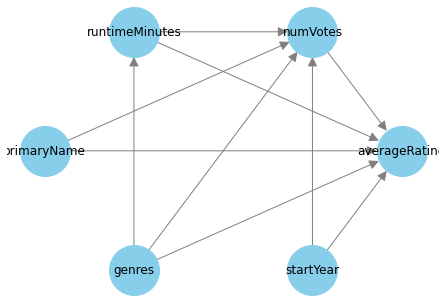

In [4]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "runtimeMinutes", "primaryName", "genres"]
G.add_nodes_from(nodes)


edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "numVotes"),
    ("numVotes", "averageRating"),
    ("runtimeMinutes", "numVotes"),
    ("runtimeMinutes", "averageRating"),
    ("genres", "numVotes"),
    ("genres", "runtimeMinutes"),
    ("genres", "averageRating"),
    ("startYear", "averageRating"),
    ("startYear", "numVotes")
]
G.add_edges_from(edges)


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

In [5]:
new_G_combined=ranking_funcs.get_new_G_combined(G,df)
new_G_combined_rf=ranking_funcs.get_new_G_combined_rf(G,df)

In [11]:
updated_df=ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':10},"fix")

X=df[["numVotes", "runtimeMinutes", "primaryName", "genres", "startYear"]]
y=df["averageRating"]

updated_df_X=updated_df[["numVotes", "runtimeMinutes", "primaryName", "genres", "startYear"]]
updated_df_y=updated_df["averageRating"]

In [12]:
rf_estimator=RandomForestRegressor(random_state=1234).fit(X, y)
rf_result=rf_estimator.predict(updated_df_X)
updated_df['rf_prediction']=rf_result
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)
rf_order

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,rf_prediction
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.0,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2,8.332119
127,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.0,3,tt0083987,movie,Gandhi,Gandhi,0,0,\N,2,2,8.332119
216,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.5,3,tt0482571,movie,The Prestige,The Prestige,0,1,\N,1,2,8.009540
213,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0416320,tt0416320,7.6,3,tt0416320,movie,Match Point,Match Point,0,1,\N,1,2,8.009540
401,nm1165110,11,1983,\N,"actor,producer,soundtrack","tt0796366,tt1735898,tt3501632,tt0848228",tt4154796,tt4154796,8.4,3,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0,2,\N,2,1,7.895111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0318081,tt0318081,4.2,1,tt0318081,movie,A Sound of Thunder,A Sound of Thunder,0,1,\N,0,1,4.265481
163,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0462396,tt0462396,5.4,1,tt0462396,movie,The Last Legion,The Last Legion,0,1,\N,0,1,4.265481
150,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0167456,tt0167456,4.3,1,tt0167456,movie,Thunderbirds,Thunderbirds,0,1,\N,0,1,4.265481
418,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1475569,tt1475569,2.5,0,tt1475569,movie,I.C.U.,I.C.U.,0,1,\N,0,4,4.015167


In [13]:
X_const = sm.add_constant(X)
updated_X_const = sm.add_constant(updated_df_X)
ols_model = sm.OLS(y, X_const).fit()
ols_result = ols_model.predict(updated_X_const)
updated_df['ols_prediction']=ols_result
ols_order=updated_df.sort_values(by='ols_prediction',ascending=False)

In [14]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined_rf, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':10},"fix")

backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined_rf, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':10},"fix")

In [15]:
rf_results=[]
rf_results_in_topk=[]

ols_results = []
ols_results_in_topk = []

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))
    
    ols_results.append(ranking_funcs.accuracy_topk_rank(ols_order.head(i).index,updated_df.head(i).index))
    ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_order.head(i).index,updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))

In [16]:
df_top_k_accuracy=pd.DataFrame({'Random forest':rf_results,'linear regression':ols_results,
                               'Hyper:Backdoor Criterion':back_door_opt1_with_combined_G,
                                'Hyper:BSCPM':back_door_opt2_with_combined_G,
                               'Top_k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'Random forest':rf_results_in_topk,'linear regression':ols_results_in_topk,
                               'Hyper:Backdoor Criterion':back_door_opt1_with_combined_G_in_topk,
                                'Hyper:BSCPM':back_door_opt2_with_combined_G_in_topk,
                                'Top_k_range':range(1,len(updated_df)+1)})

In [17]:
df_in_top_k_accuracy.head(10)

,Random forest,linear regression,Hyper:Backdoor Criterion,Hyper:BSCPM,Top_k_range
0,1.000000,0.000000,1.000000,1.000000,1
1,0.500000,0.500000,0.500000,0.500000,2
2,0.666667,0.333333,0.333333,0.333333,3
3,0.500000,0.250000,0.250000,0.500000,4
4,0.600000,0.200000,0.200000,0.600000,5
5,0.500000,0.166667,0.166667,0.500000,6
6,0.428571,0.142857,0.142857,0.428571,7
7,0.375000,0.125000,0.125000,0.625000,8
8,0.333333,0.222222,0.111111,0.666667,9
9,0.300000,0.200000,0.100000,0.600000,10


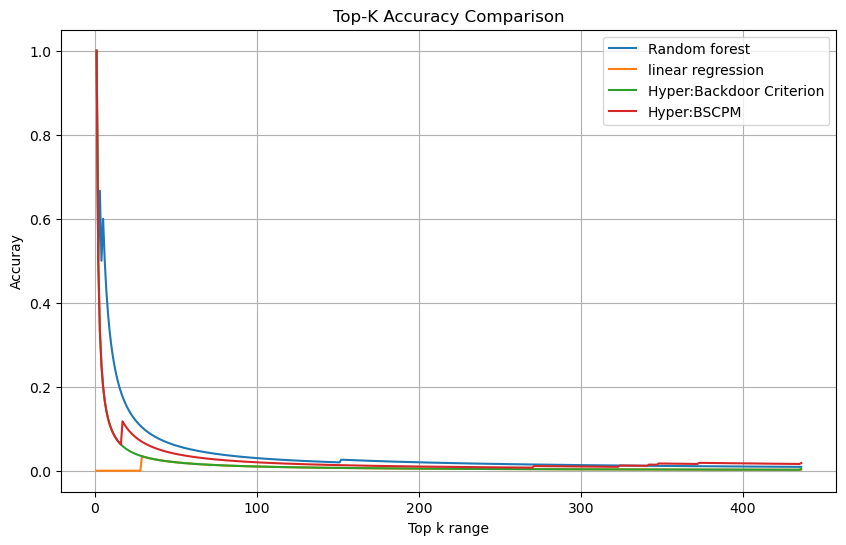

In [18]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["Top_k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("Top k range")
plt.ylabel("Accuray")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison.png')

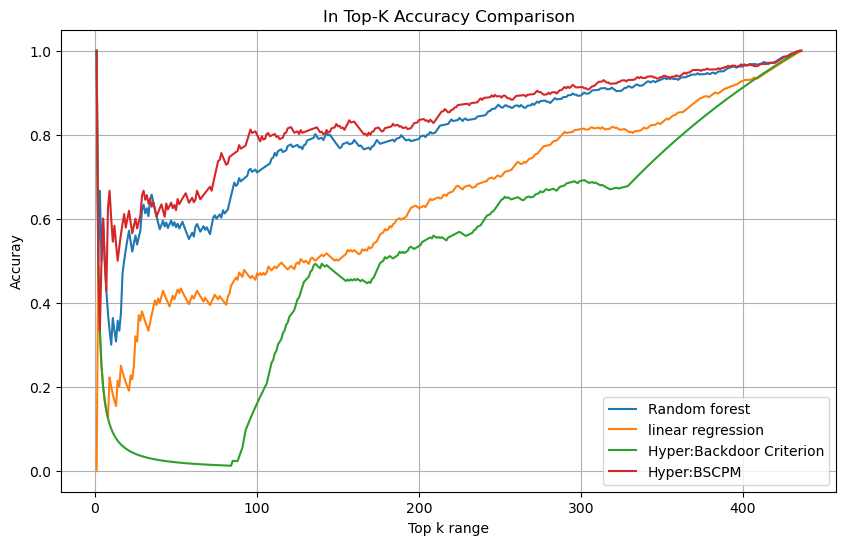

In [19]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["Top_k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("Top k range")
plt.ylabel("Accuray")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison.png')
plt.show()

In [20]:
updated_df['true_row_index']=updated_df.index
rf_order['true_row_index']=rf_order.index
ols_order['true_row_index']=ols_order.index
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')
merged_df['true_row_index']=merged_df.index

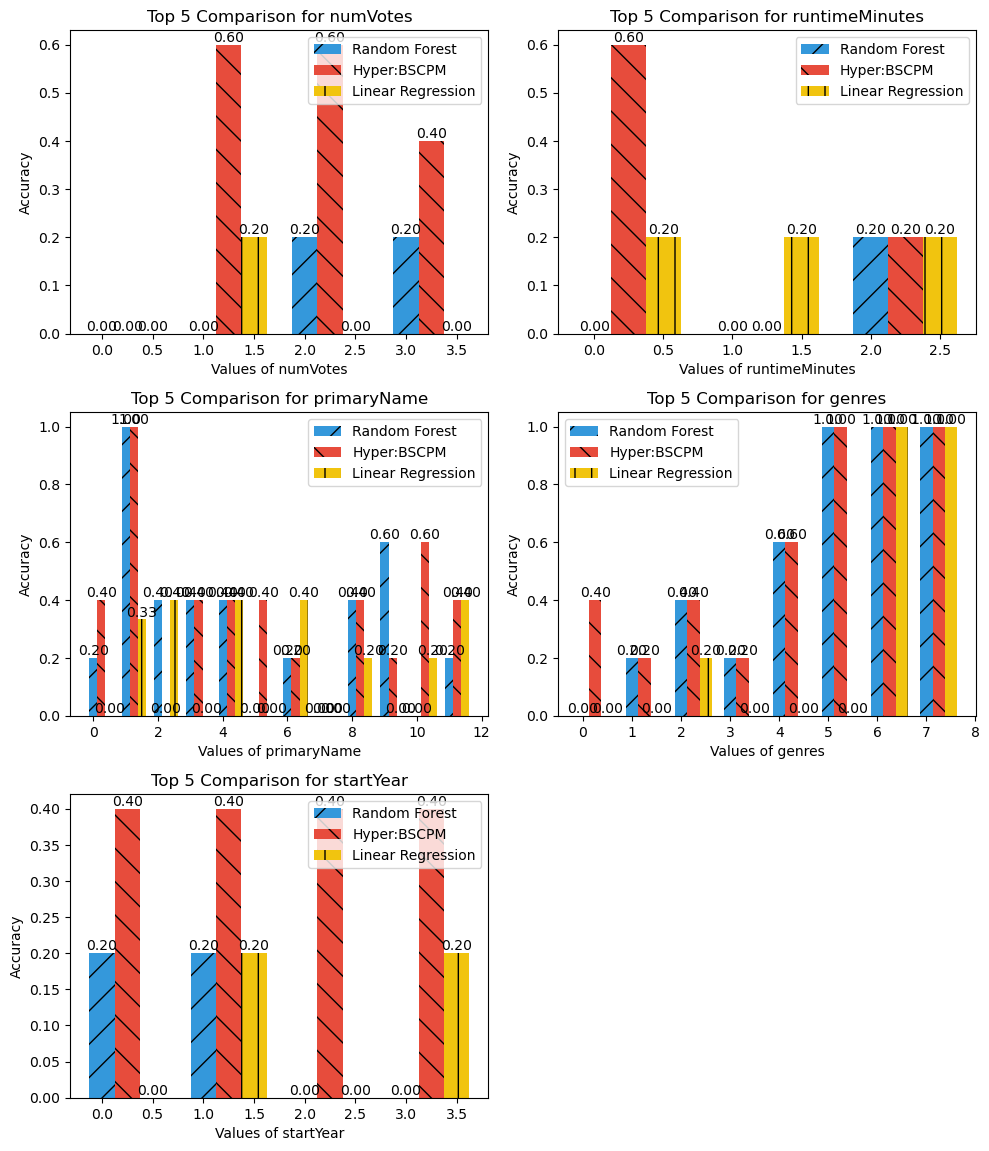

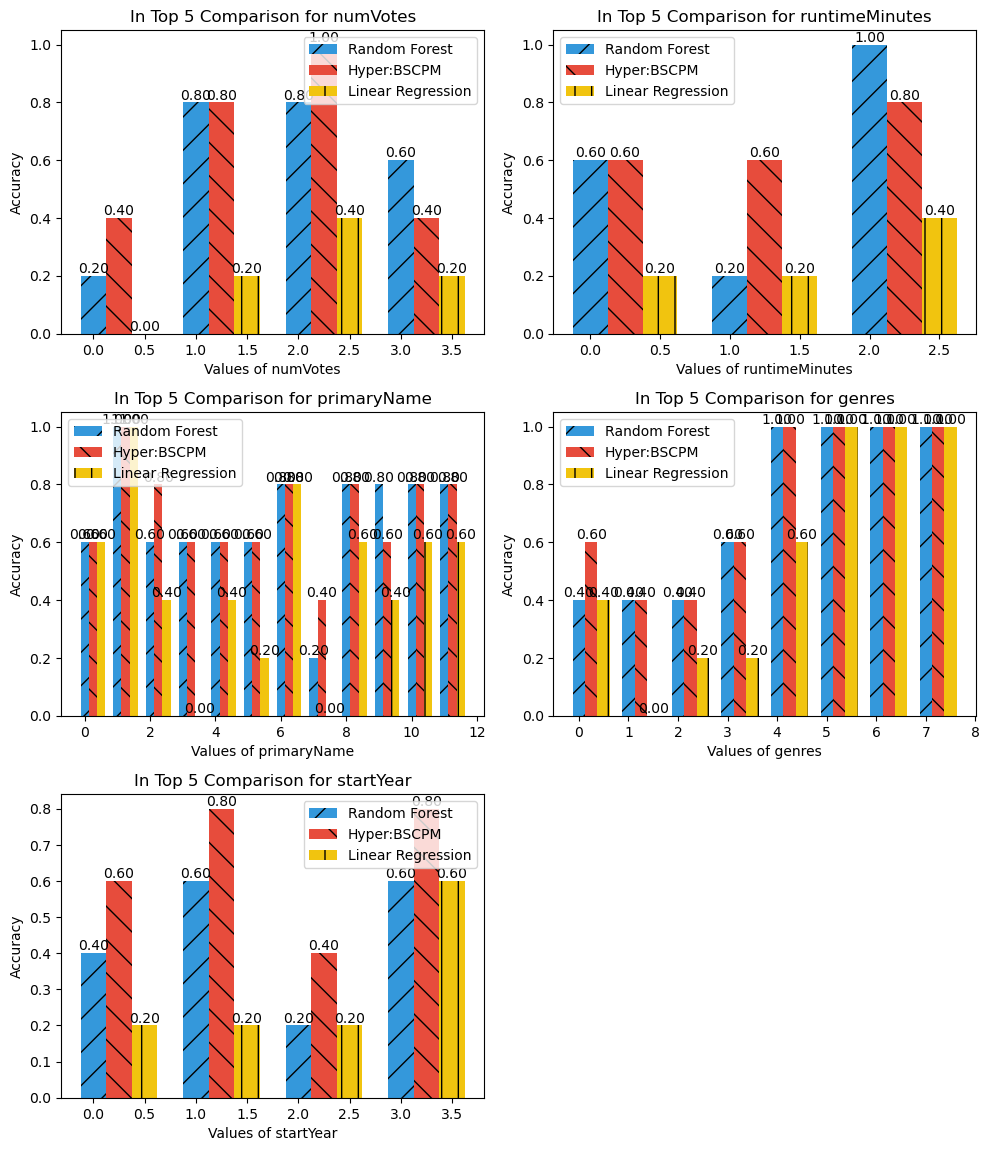

In [21]:
Xs = ["numVotes", "runtimeMinutes", "primaryName", "genres", "startYear"]


plt.figure(figsize=(10, 3 * len(Xs)))

colors = {
    'random_forest': '#3498db', 
    'backdoor_method2_with_combined_effect': '#e74c3c', 
    'OLS': '#f1c40f' 
}

hatches = ['/', '\\', '|', '-']


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest', hatch=hatches[0])
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Hyper:BSCPM', hatch=hatches[1])
    bars3 = plt.bar(r3, df_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='Linear Regression', hatch=hatches[2])
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_5_comparison_all_features.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest', hatch=hatches[0])
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Hyper:BSCPM', hatch=hatches[1])
    bars3 = plt.bar(r3, df_in_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='Linear Regression', hatch=hatches[2])
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')
            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 5 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_5_comparison_all_features.png')
plt.show()

In [17]:
ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.700000,0,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2
216,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.500000,3,tt0482571,movie,The Prestige,The Prestige,0,1,\N,1,2
379,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt6246170,tt6246170,8.500000,0,tt6246170,movie,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,0,2,\N,1,5
416,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt11852794,tt11852794,8.408852,3,tt11852794,movie,Under Cover,Under Cover,0,3,\N,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0171825,tt0171825,3.400000,0,tt0171825,movie,The Thin Pink Line,The Thin Pink Line,0,0,\N,0,0
372,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt4642936,tt4642936,3.100000,0,tt4642936,movie,Warrior Savitri,Warrior Savitri,0,2,\N,1,1
160,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.000000,1,tt0383222,movie,BloodRayne,BloodRayne,0,1,\N,0,1
168,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0955411,tt0955411,2.900000,0,tt0955411,movie,The Ten Commandments,The Ten Commandments,0,1,\N,0,3


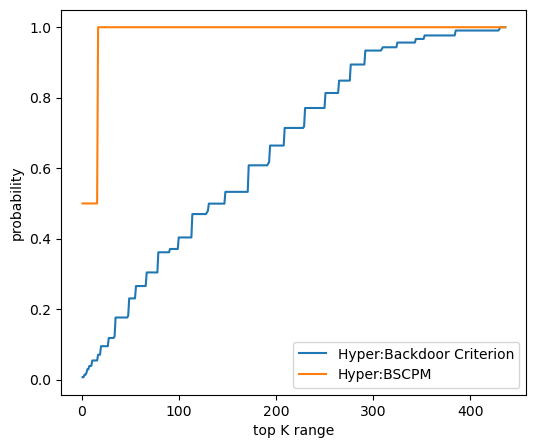

In [22]:
k_range_backdoor_val,k_range_backdoor2_val=ranking_funcs.k_range_backdoor(new_G_combined,new_G_combined_rf, df, 1, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [140],len(df))
x_values = range(1, len(df)+1)    
plt.figure(figsize=(6, 5))
plt.plot(x_values, k_range_backdoor_val, label='Hyper:Backdoor Criterion')
plt.plot(x_values, k_range_backdoor2_val, label='Hyper:BSCPM')
plt.xlabel('top K range')
plt.ylabel('probability')
plt.legend()

plt.savefig(f'ranking_plots/topk_range_backdoor.png')
plt.show()

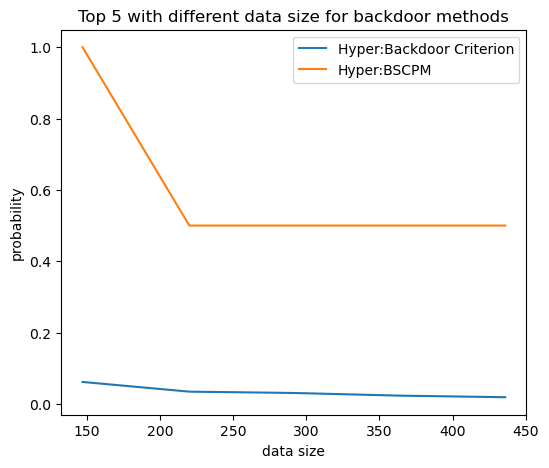

In [23]:
lenth,data_size_backdoor_val,data_size_backdoor2_val=ranking_funcs.data_size_backdoor(new_G_combined,new_G_combined_rf, df, 5, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [140],6,123)
plt.figure(figsize=(6, 5))
plt.plot(lenth, data_size_backdoor_val, label='Hyper:Backdoor Criterion')
plt.xlabel('data size')
plt.ylabel('probability')

plt.plot(lenth, data_size_backdoor2_val, label='Hyper:BSCPM')
plt.xlabel('data size')
plt.ylabel('probability')
plt.title(f'Top 5 with different data size for backdoor methods')
plt.legend()

plt.savefig(f'ranking_plots/topk_backdoor_range.png')
plt.show()

In [33]:
var=['numVotes']
df_gr_combined=ranking_funcs.Greedy_Algo(new_G_combined, df, 5, 'averageRating',var,0, {'primaryName':7},50, opt="add",force=2)
df_gr_combined

,rank,prob,total_iters
0,"[320, 379, 279, 140, 278]",0.02,1.0
1,"[320, 379, 279, 278, 308]",0.06,3.0
2,"[320, 379, 279, 308, 278]",0.92,46.0


In [34]:
row_indexes=[320, 379, 279, 308, 278]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'averageRating',var,1, {'primaryName':7} ,50, opt="add",force=2)

gbval1=np.sum(greedy_backdoor)/50
gbval2=np.sum(greedy_backdoor2)/50

In [35]:
row_indexes=[320, 379, 279, 140, 278]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'averageRating',var,1, {'primaryName':7} ,50, opt="add",force=2)

gbval11=np.sum(greedy_backdoor)/50
gbval22=np.sum(greedy_backdoor2)/50

In [36]:
baseline_val=ranking_funcs.base_line(df,5)**5

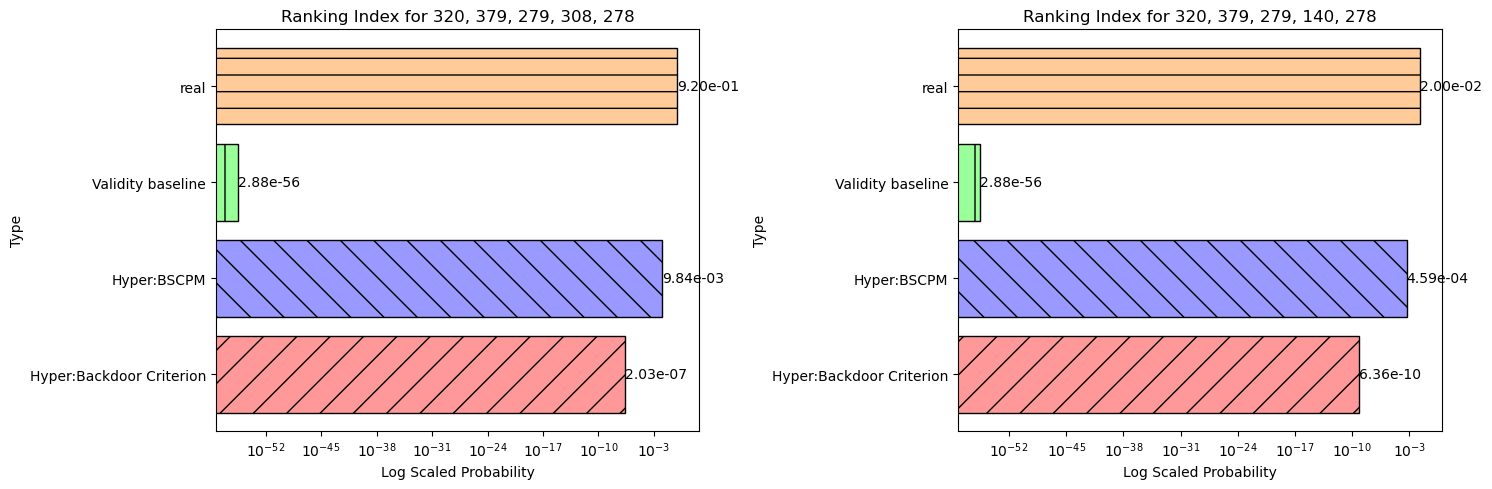

In [37]:

data1 = {'Hyper:Backdoor Criterion': gbval1,'Hyper:BSCPM': gbval2, 'Validity baseline':baseline_val,'real': 0.92}
data2 = {'Hyper:Backdoor Criterion': gbval11,'Hyper:BSCPM':gbval22,  'Validity baseline':baseline_val,'real': 0.02}

data=[data1, data2]

types = ['Hyper:Backdoor Criterion','Hyper:BSCPM','Validity baseline','real']

colors = {'Hyper:Backdoor Criterion': '#FF9999', 'Hyper:BSCPM': '#9999FF', 'Validity baseline': '#99FF99', 'real': '#FFCC99'}

titles = [
    "Ranking Index for 320, 379, 279, 308, 278",
    "Ranking Index for 320, 379, 279, 140, 278"
]


hatches = ['/', '\\', '|', '-']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, d in enumerate(data):
    values = [d[t] for t in types]  
    keys = types  
    colors_list = [colors[t] for t in keys] 

    bars = axes[i].barh(keys, values, color=colors_list, edgecolor='black')
    
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Type')
    axes[i].set_yticks(range(len(keys)))
    axes[i].set_yticklabels(keys)
    axes[i].set_xlabel('Log Scaled Probability')
    axes[i].set_xscale('log')
    

    for bar, value in zip(bars, values):
        axes[i].text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 '{:.2e}'.format(value), va='center')

plt.tight_layout()
plt.savefig(f'ranking_plots/greedy_noncg.png')
plt.show()

In [38]:
import time

In [39]:
def Comp_Greedy_Algo_backdoor2(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    prob_result2=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result2

In [40]:
df_subsets=df.head(50)
iter_times=[10,50,100,150,200,250,300,350]
var=['numVotes']
time_greedy_algo=[]

for i in iter_times:
    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df_subsets, 5, 'averageRating',var,0, {'primaryName':6},i, opt="add",force=2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)

time_greedy_backdoor=[]
row_indexes=[5, 4, 6, 7, 8]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G_combined, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,i, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)

time_greedy_backdoor2=[]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G_combined, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,i, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)

In [52]:
time_greedy = pd.DataFrame({'Iteration times':iter_times,'Hyper:Naive algorithm':time_greedy_algo,'Hyper:Backdoor Criterion':time_greedy_backdoor,'Hyper:BSCPM':time_greedy_backdoor2})

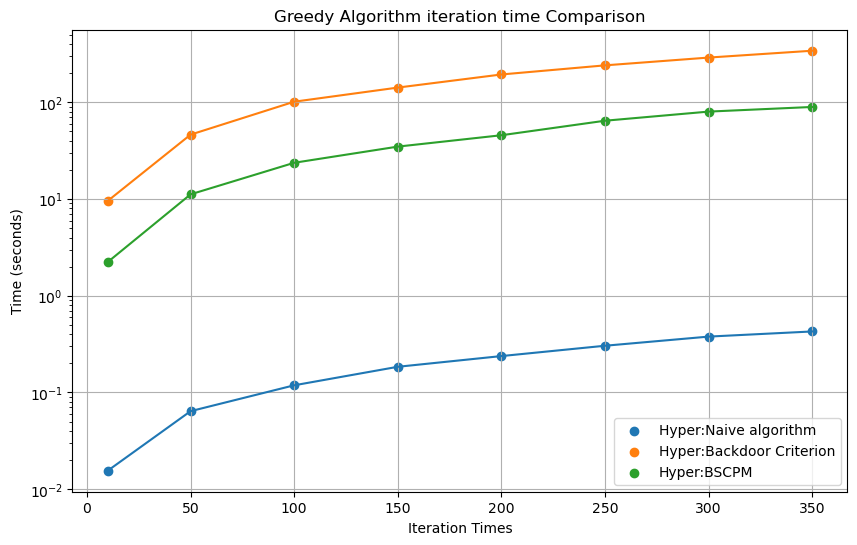

In [85]:
plt.figure(figsize=(10, 6))
for column in time_greedy.columns[1:]:
    plt.scatter(time_greedy["Iteration times"], time_greedy[column], label=column)
    plt.plot(time_greedy["Iteration times"], time_greedy[column])

ax = plt.gca()  
ax.set_yscale('log')
plt.xlabel("Iteration Times")
plt.ylabel("Time (seconds)")
plt.title("Greedy Algorithm iteration time Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/time_comparision_greedy.png')
plt.show()

In [62]:
i_range=[10,50,100,150,200,250,300]
time_greedy_algo_data=[]
var=['numVotes']
time_greedy_backdoor_data=[]
row_indexes=[5, 4, 6, 7, 8]
time_greedy_backdoor2_data=[]
df_rows=df.loc[row_indexes]
df_dropped = df.copy().drop(row_indexes)

for i in i_range:
    df_subsets=pd.concat([df_dropped.sample(i-5),df_rows])

    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df_subsets, 5, 'averageRating',var,0, {'primaryName':6},10, opt="add",force=2)
    end_time = time.time()
    time_greedy_algo_data.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G_combined, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,10, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor_data.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G_combined, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,10, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor2_data.append(end_time - start_time)

In [81]:
time_greedy_algo_data=[]
for i in i_range:
    df_subsets=pd.concat([df_dropped.sample(i-5),df_rows])

    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df_subsets, 5, 'averageRating',var,0, {'primaryName':6},1000, opt="add",force=2)
    end_time = time.time()
    time_greedy_algo_data.append(end_time - start_time)

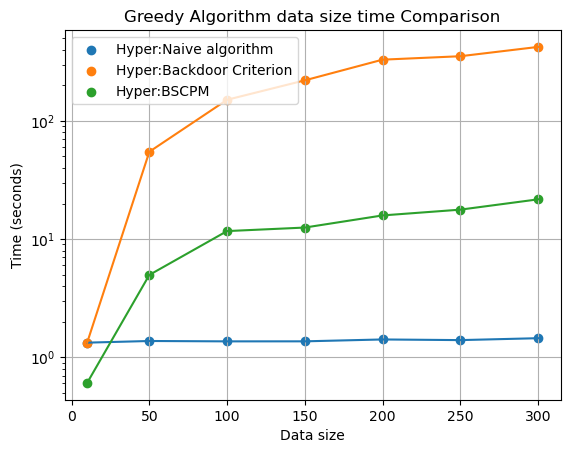

In [86]:
time_greedy_data = pd.DataFrame({'Data_size':i_range,'Hyper:Naive algorithm':time_greedy_algo_data,'Hyper:Backdoor Criterion':time_greedy_backdoor_data,'Hyper:BSCPM':time_greedy_backdoor2_data})

for column in time_greedy.columns[1:]:
    plt.scatter(time_greedy_data["Data_size"], time_greedy_data[column], label=column)
    plt.plot(time_greedy_data["Data_size"], time_greedy_data[column])

ax = plt.gca()  
ax.set_yscale('log')
plt.xlabel("Data size")
plt.ylabel("Time (seconds)")
plt.title("Greedy Algorithm data size time Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/time_comparision_data.png')
plt.show()


In [133]:
tok_k_prob_df=ranking_funcs.get_ranking_query_prob(new_G_combined, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix')
top5_ranking_probs=ranking_funcs.filter_prob_df(tok_k_prob_df)
for idx in [140, 320, 379,216,400]:
    if idx in top5_ranking_probs.index:
        print(top5_ranking_probs.loc[idx])

row_index    140.0
1              1.0
2              0.0
3              0.0
4              0.0
5              0.0
Name: 140, dtype: float64
row_index    320.0
1              0.0
2              1.0
3              0.0
4              0.0
5              0.0
Name: 320, dtype: float64
row_index    379.0
1              0.0
2              0.0
3              0.5
4              0.5
5              0.0
Name: 379, dtype: float64
row_index    216.0
1              0.0
2              0.0
3              0.5
4              0.5
5              0.0
Name: 216, dtype: float64
row_index    400.0
1              0.0
2              0.0
3              0.0
4              0.0
5              0.5
Name: 400, dtype: float64


In [184]:
upf = ranking_funcs.get_ranking_query(new_G_combined, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix')

upf

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,9.372568,2,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2
379,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt6246170,tt6246170,9.172568,2,tt6246170,movie,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,0,2,\N,1,5
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
279,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0088837,tt0088837,8.872568,2,tt0088837,movie,"Hamara Shahar - Bombay, Our City","Hamara Shahar - Bombay, Our City",0,0,\N,0,3
308,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0249359,tt0249359,8.772568,2,tt0249359,movie,Ankuram,Ankuram,0,0,\N,1,2


In [176]:
ranking_funcs.get_ranking_query(new_G_combined_rf, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,9.164726,2,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
379,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt6246170,tt6246170,8.964726,2,tt6246170,movie,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,0,2,\N,1,5
279,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0088837,tt0088837,8.664726,2,tt0088837,movie,"Hamara Shahar - Bombay, Our City","Hamara Shahar - Bombay, Our City",0,0,\N,0,3
278,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0085178,tt0085178,8.564726,2,tt0085178,movie,Ardh Satya,Ardh Satya,0,0,\N,1,2


In [177]:
theta = 8.772568
theta_rf = 8.564726

In [166]:
real_G_bk1 = ranking_funcs.get_prob_backdoor_opt(new_G_combined, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix',upf.index,theta)

rf_G_bk1 = ranking_funcs.get_prob_backdoor_opt(new_G_combined_rf, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix',upf.index,theta_rf)

real_G_bk2 = ranking_funcs.get_prob_backdoor_opt2(new_G_combined, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix',upf.index,theta)

rf_G_bk2 = ranking_funcs.get_prob_backdoor_opt2(new_G_combined_rf, df, 5, {'numVotes':2}, 'averageRating',
                                     {'primaryName':7},'fix',upf.index,theta_rf)

real = 0.5



In [167]:
upf.index

Index([320, 140, 379, 279, 278], dtype='int64')

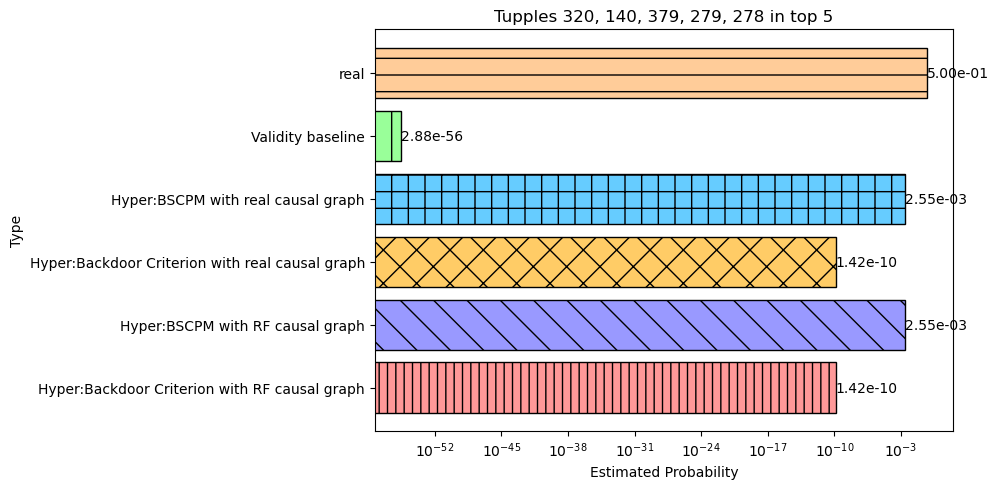

In [179]:
data = {'Hyper:Backdoor Criterion with RF causal graph': rf_G_bk1.iloc[0],
        'Hyper:BSCPM with RF causal graph': rf_G_bk2,
        'Hyper:Backdoor Criterion with real causal graph':real_G_bk1.iloc[0],
        'Hyper:BSCPM with real causal graph':real_G_bk2,
        'Validity baseline':baseline_val,
        'real': real}

types = [
    'Hyper:Backdoor Criterion with RF causal graph',
    'Hyper:BSCPM with RF causal graph',
    'Hyper:Backdoor Criterion with real causal graph',
    'Hyper:BSCPM with real causal graph',
    'Validity baseline',
    'real',
]

colors = {
    'Hyper:Backdoor Criterion with RF causal graph': '#FF9999',
    'Hyper:BSCPM with RF causal graph': '#9999FF',
    'Hyper:Backdoor Criterion with real causal graph': '#FFCC66',
    'Hyper:BSCPM with real causal graph': '#66CCFF',
    'Validity baseline': '#99FF99',
    'real': '#FFCC99',
}

titles = ["Tupples 320, 140, 379, 279, 278 in top 5"]
hatches = ['||', '\\', 'x', '+', '|', '-']

fig, ax = plt.subplots(figsize=(10, 5))

values = [data[t] for t in types]
keys = types
colors_list = [colors[t] for t in types]

bars = ax.barh(keys, values, color=colors_list, edgecolor='black')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.set_title(titles[0])
ax.set_ylabel('Type')
ax.set_yticks(range(len(keys)))
ax.set_yticklabels(keys)
ax.set_xlabel('Estimated Probability')
ax.set_xscale('log')

for bar, value in zip(bars, values):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            '{:.2e}'.format(value), va='center')

plt.tight_layout()
plt.savefig('ranking_plots/dif_est_prob.png') 
plt.show()

In [28]:
df.sort_values(by='averageRating',ascending=False)[['primaryTitle','primaryName','averageRating']]

,primaryTitle,primaryName,averageRating
140,Schindler's List,6,9.0
320,Long Da Lishkara,7,8.7
216,The Prestige,0,8.5
379,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,7,8.5
400,Avengers: Infinity War,11,8.4
...,...,...,...
160,BloodRayne,6,3.0
168,The Ten Commandments,6,2.9
419,Vigilante,2,2.6
382,Gul Makai,7,2.6


In [44]:
indes = [140, 320, 216]

In [46]:
for i in range(6):
    tok_k_prob_df = ranking_funcs.get_ranking_query_prob(new_G_combined, df, 3, {'numVotes':i}, 'averageRating',{'primaryTitle':'The Prestige'},'fix')
    top3_ranking_probs = ranking_funcs.filter_prob_df(tok_k_prob_df)
    print(i)
    print('---------------')
    for idx in indes:
        if idx in top3_ranking_probs.index:
            print(top3_ranking_probs.loc[idx])
        else:
            print(f"Index {idx} not found.")

0
---------------
row_index    140
1              1
2              0
3              0
Name: 140, dtype: int64
row_index    320
1              0
2              1
3              0
Name: 320, dtype: int64
Index 216 not found.
1
---------------
row_index    140
1              1
2              0
3              0
Name: 140, dtype: int64
row_index    320
1              0
2              1
3              0
Name: 320, dtype: int64
Index 216 not found.
2
---------------
row_index    140
1              1
2              0
3              0
Name: 140, dtype: int64
row_index    320
1              0
2              1
3              0
Name: 320, dtype: int64
Index 216 not found.
3
---------------
row_index    140.0
1              1.0
2              0.0
3              0.0
Name: 140, dtype: float64
row_index    320.0
1              0.0
2              1.0
3              0.0
Name: 320, dtype: float64
row_index    216.0
1              0.0
2              0.0
3              0.5
Name: 216, dtype: float64
4
-----

In [6]:
stable_rank_fix=ranking_funcs.get_stable_ranking_opt(new_G_combined, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},100,'multiply_by')
stable_rank_fix

Lower Bound Change: (Value: 2.2365656864010135, Iteration: 23)
Upper Bound Change: (Value: 4.0240266828390885, Iteration: 23)


[[2.2365656864010135, 4.0240266828390885], [23, 23]]

In [19]:
ranking_funcs.test_revert_ranking_rec_multi(new_G_combined, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},
                            stable_rank_fix,1000,0,3,'lower')

[2.208190096349103, 24, 'update lower']
2.208190096349103
Lower Bound Change: (Value: 1.8704618700557536, Iteration: 13)
Upper Bound Change: (Value: 2.606898103444856, Iteration: 13)
[1.8467310851496155, 14, 'update lower']
1.8467310851496155
Lower Bound Change: (Value: 1.6674086898621456, Iteration: 8)
Upper Bound Change: (Value: 2.0453388072121865, Iteration: 8)
[1.6462540661816507, 9, 'update lower']
1.6462540661816507
Lower Bound Change: (Value: 1.325038395039098, Iteration: 17)
Upper Bound Change: (Value: 2.0453388072121865, Iteration: 17)
[1.3082274663329652, 18, 'update lower']
1.3082274663329652
Lower Bound Change: (Value: 1.0664980481415307, Iteration: 16)
Upper Bound Change: (Value: 1.6047465878163973, Iteration: 16)


'the iteration ends'

In [10]:
ranking_funcs.get_ranking_query(new_G_combined, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},'multiply_by')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
253,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt1663662,tt1663662,8.917704,9,tt1663662,movie,Pacific Rim,Pacific Rim,0,2,\N,1,1
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.700000,0,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2


In [16]:
x_sd = np.abs(df['numVotes'].std() * 0.01)

In [47]:
ranking_funcs.get_ranking_query(new_G_combined, df, 3, {'numVotes':2.2365656864010135*(1+x_sd*23)}, 'averageRating',{'primaryName':5},'multiply_by')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3.000000,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
253,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt1663662,tt1663662,8.814388,8.692772,tt1663662,movie,Pacific Rim,Pacific Rim,0,2,\N,1,1
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.700000,0.000000,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2


In [21]:
ranking_funcs.stable_ranking_opt_multi(new_G_combined, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},100)

Lower Bound Change: (Value: 2.2365656864010135, Iteration: 23)
Upper Bound Change: (Value: 4.0240266828390885, Iteration: 23)


[[2.2365656864010135, 4.0240266828390885], [23, 23]]

In [22]:
ranking_funcs.get_ranking_query(new_G_combined, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},'multiply_by')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
253,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt1663662,tt1663662,8.917704,9,tt1663662,movie,Pacific Rim,Pacific Rim,0,2,\N,1,1
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.700000,0,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2


In [24]:
ranking_funcs.get_ranking_query(new_G_combined, df, 3, {'numVotes':2.2365656864010135*(1+23*x_sd)}, 'averageRating',{'primaryName':5},'multiply_by')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3.000000,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
253,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt1663662,tt1663662,8.814388,8.692772,tt1663662,movie,Pacific Rim,Pacific Rim,0,2,\N,1,1
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.700000,0.000000,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2


In [41]:
ranking_funcs.get_ranking_query(new_G_combined, df, 3, {'numVotes':1.0664980481415307*(1+81*x_sd)}, 'averageRating',{'primaryName':5},'multiply_by')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.0,3.0,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.7,0.0,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2
216,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.5,3.0,tt0482571,movie,The Prestige,The Prestige,0,1,\N,1,2


In [42]:
2.2365656864010135*(1+23*x_sd)

2.8975907658846536

In [40]:
1.0664980481415307*(1+81*x_sd)

2.1765761287724272

In [51]:
G = new_G_combined
k = 3
update_vars = {'numVotes':3}
target_column = 'averageRating'
condition = {'primaryName':5}
opt = 'multiply_by'
updated_df = ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
### the updated variable
nodes = update_vars.keys()
results = []
### k th ranking value of updated dataframe
theta = updated_df[target_column].iloc[k-1]
### k-1 th ranking value of updated dataframe
prev_theta = updated_df[target_column].iloc[k-2]

### since we only have one updated variable
for node in nodes:
    ### find the one of the backdoor set of updated variable
    bd_sets = ranking_funcs.find_backdoor_sets_opt(G, target_column, node)
    for bd_set in bd_sets:
        dom_y = updated_df[target_column].unique()
        dom_node = updated_df[node].unique()
        for d_y in dom_y:
            for d_n in dom_node:
                adjusted_prob = ranking_funcs.backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                results.append({
                    'Y': target_column, 
                    'Y_value': d_y, 
                    'X': node, 
                    'X_value': d_n, 
                    'Z': ', '.join(bd_set), 
                    'prob': adjusted_prob
                })
prob_df = pd.DataFrame(results)

In [ ]:
def backdoor_adjustment_opt(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0  
    unique_Z_combinations = df[Z].drop_duplicates()
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            p_Z = len(df_Z) / total_len
            total_relevant_Z += len(df_Z)
            prob += p_Y_given_A_Z * p_Z
    if total_relevant_Z > 0:
        prob = prob * total_len / total_relevant_Z

    return prob

In [74]:
G = new_G_combined
k = 3
update_vars = {'numVotes':3}
target_column = 'averageRating'
condition = {'primaryName':5}
opt = 'multiply_by'
updated_df = ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
### the updated variable
node = list(update_vars.keys())[0]
results = []
### k th ranking value of updated dataframe
theta = updated_df[target_column].iloc[k-1]
### k-1 th ranking value of updated dataframe
prev_theta = updated_df[target_column].iloc[k-2]

### since we only have one updated variable

    ### find the one of the backdoor set of updated variable

bd_sets = ranking_funcs.find_backdoor_sets_opt(G, target_column, node)
for bd_set in bd_sets:
    dom_y = updated_df[target_column].unique()
    dom_node = updated_df[node].unique()
    for d_y in dom_y:
        for d_n in dom_node:
            adjusted_prob = ranking_funcs.backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
            results.append({
                'Y': target_column, 
                'Y_value': d_y, 
                'X': node, 
                'X_value': d_n, 
                'Z': ', '.join(bd_set), 
                'prob': adjusted_prob
            })
prob_df2 = pd.DataFrame(results)

In [75]:
prob_df2

,Y,Y_value,X,X_value,Z,prob
0,averageRating,9.0,numVotes,3,"startYear, genres, runtimeMinutes, primaryName",0.006977
1,averageRating,9.0,numVotes,9,"startYear, genres, runtimeMinutes, primaryName",0.000000
2,averageRating,9.0,numVotes,0,"startYear, genres, runtimeMinutes, primaryName",0.000000
3,averageRating,9.0,numVotes,6,"startYear, genres, runtimeMinutes, primaryName",0.000000
4,averageRating,9.0,numVotes,1,"startYear, genres, runtimeMinutes, primaryName",0.000000
...,...,...,...,...,...,...
349,averageRating,2.5,numVotes,9,"startYear, genres, runtimeMinutes, primaryName",0.000000
350,averageRating,2.5,numVotes,0,"startYear, genres, runtimeMinutes, primaryName",0.004167
351,averageRating,2.5,numVotes,6,"startYear, genres, runtimeMinutes, primaryName",0.000000
352,averageRating,2.5,numVotes,1,"startYear, genres, runtimeMinutes, primaryName",0.000000


In [88]:
def get_prob_backdoor_opt(G, df, k, update_vars, target_column, condition, opt, row_indexes,theta):
    ### get the updated dataframe
    updated_df = ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    ### the updated variable
    node = list(update_vars.keys())[0]
    results = []
    ### find the one of the backdoor set of updated variable
    bd_set = ranking_funcs.find_backdoor_sets_opt(G, target_column, node)[0]
    dom_y = updated_df[target_column].unique()
    dom_node = updated_df[node].unique()
    for d_y in dom_y:
        for d_n in dom_node:
            adjusted_prob = ranking_funcs.backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
            results.append({
                'Y': target_column, 
                'Y_value': d_y, 
                'X': node, 
                'X_value': d_n, 
                'Z': ', '.join(bd_set), 
                'prob': adjusted_prob
            })
    ## get the probability dataframe
    prob_df = pd.DataFrame(results)
    
    z_relevant_probs = prob_df[(prob_df['Y_value'] >= theta)]
    prob_groups = []
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        x_value = row[node]
        prob_sum = z_relevant_probs[(z_relevant_probs['X_value'] == x_value)]['prob'].sum()
        prob_groups.append(prob_sum)
        
    return m.prod(prob_groups)

In [ ]:
def get_prob_backdoor_opt_edit1(G, df, k, update_vars, target_column, condition, opt, row_indexes):
    ### get the updated dataframe
    updated_df = ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    ### the updated variable
    node = list(update_vars.keys())[0]
    results = []
    ### k th ranking value of updated dataframe, generate the theta list
    theta = updated_df[target_column].iloc[k-1]
    ### k-1 th ranking value of updated dataframe, generate the prev theta list
    prev_theta = updated_df[target_column].iloc[k-2]
    ### find the backdoor set path
    bd_set = ranking_funcs.find_backdoor_sets_opt(G, target_column, node)[0]
    #### get unique values of Y
    dom_y = updated_df[target_column].unique()
    #### get unique values of updated variable
    dom_node = updated_df[node].unique()
    #### iteration to get the probaility Sum 𝑃𝑟 (𝑌 = 𝑦|𝑑𝑜 (𝑋 ) = 𝑥, 𝑍 = 𝑧𝑖 )𝑃𝑟 (𝑍 =𝑧𝑖 ) to calculate 𝑃𝑟 (𝑌 = 𝑦|𝑑𝑜 (𝑋 ) = 𝑥)
    for d_y in dom_y:
        for d_n in dom_node:
            adjusted_prob = ranking_funcs.backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
            results.append({
                'Y': target_column, 
                'Y_value': d_y, 
                'X': node, 
                'X_value': d_n, 
                'Z': ', '.join(bd_set), 
                'prob': adjusted_prob
            })
    ## get the probability dataframe
    prob_df = pd.DataFrame(results)
    
    ### filter the Y values >𝜃k and corresponding probability
    z_relevant_probs = prob_df[(prob_df['Y_value'] > theta)]
    ### filter the Y values (>𝜃k and <=𝜃k −1) and corresponding probability
    z_relevant_probs2 = z_relevant_probs[(z_relevant_probs['Y_value'] <= prev_theta)].copy
    prob_groups = []
    ### calculate the probability of each tupple
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        x_value = row[node]
        ###  𝑃𝑟 (𝑌 = 𝑦𝑗 |𝑑𝑜 (𝑋 ) = 𝑥) with 𝑦𝑗 ≥ 𝜃k - 𝑃𝑟 (𝑌 = 𝑦𝑗 |𝑑𝑜 (𝑋 ) = 𝑥) with 𝑦𝑗 ≥ 𝜃k and yj<=𝜃k-1
        prob_sum = z_relevant_probs[(z_relevant_probs['X_value'] == x_value)]['prob'].sum()-
        z_relevant_probs2[(z_relevant_probs2['X_value'] == x_value)]['prob'].sum()
        prob_groups.append(prob_sum)
        ### get the product of probability of each tupple
    return m.prod(prob_groups)

In [ ]:
def get_prob_backdoor_opt_edit2(G, df, k, update_vars, target_column, condition, opt, row_indexes):
    ### get the updated dataframe
    updated_df = ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    ### the updated variable
    node = list(update_vars.keys())[0]
    results = []
    ###  theta 2 to theta k
    theta_lst = updated_df[target_column][1:k+1]
    ###  theta 1 to theta k-1
    prev_theta_lst = updated_df[target_column][0:k]
    bd_set = ranking_funcs.find_backdoor_sets_opt(G, target_column, node)[0]
    dom_y = updated_df[target_column].unique()
    dom_node = updated_df[node].unique()
    for d_y in dom_y:
        for d_n in dom_node:
            adjusted_prob = ranking_funcs.backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
            results.append({
                'Y': target_column, 
                'Y_value': d_y, 
                'X': node, 
                'X_value': d_n, 
                'Z': ', '.join(bd_set), 
                'prob': adjusted_prob
            })
    ## get the probability dataframe
    prob_df = pd.DataFrame(results)
    
    prob_groups = []
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        x_value = row[node]
        prob_sum = 0
        for i in range(k-1):
            ### filter the Y values >𝜃i and corresponding probability
            z_relevant_probs = prob_df[(prob_df['Y_value'] > theta_lst[i])]
            ### filter the Y values (>𝜃i and <=𝜃i −1) and corresponding probability
            z_relevant_probs2 = z_relevant_probs[(z_relevant_probs['Y_value'] <= prev_theta_lst[i])].copy
            ### Pr𝐷,𝑓𝑈 𝑓 (𝜃i) - Pr𝐷,𝑓𝑈 (𝑓 (𝜃i) ∧ 𝑓 (𝜃i −1)) (sum through the iteration)
            prob_sum += z_relevant_probs[(z_relevant_probs['X_value'] == x_value)]['prob'].sum()-
            z_relevant_probs2[(z_relevant_probs2['X_value'] == x_value)]['prob'].sum()
        prob_groups.append(prob_sum)
    return m.prod(prob_groups)